# OMR Music Sheet to A MP3 file


In [10]:
import skimage.io as io
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.exposure import histogram
from skimage.filters import threshold_otsu,threshold_local,median
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv
from commonfunctions import *
from scipy.ndimage import rotate
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin, binary_opening
from skimage.measure import find_contours
from skimage.draw import rectangle

In [12]:
def histogram_equation(image):
    shape=image.shape
    H=np.zeros(256)
    for x in range(0,shape[0]):
        for y in range(0,shape[1]):
            H[image[x][y]]+=1

    return H


def getThresholdRawan(img):
    counts, _ = np.histogram(img, bins=256, range=(0, 256))
    
    total_pixels = np.sum(counts)
    print(total_pixels)
    Tinit = int(round(np.sum([i * counts[i] for i in range(256)]) / total_pixels))

    
    while True:
        if np.sum(counts[:Tinit]) == 0 or np.sum(counts[Tinit:]) == 0:
            return Tinit
        lower = np.sum([i * counts[i] for i in range(Tinit)]) / np.sum(counts[:Tinit])
        higher = np.sum([i * counts[i] for i in range(Tinit, 256)]) / np.sum(counts[Tinit:])
        new_T = int((lower + higher) / 2)
        if new_T == Tinit:
            return new_T
        Tinit = new_T

def partition_imageRawan(img, n_partitions_horiz, n_partitions_vert):
    print(img.shape)
    height, width = img.shape
    row_step = height // n_partitions_horiz
    col_step = width // n_partitions_vert
    
    binary_img = np.zeros_like(img)
    
    for i in range(n_partitions_horiz):
        for j in range(n_partitions_vert):
            row_start = i * row_step
            row_end = (i + 1) * row_step if i < n_partitions_horiz - 1 else height
            col_start = j * col_step
            col_end = (j + 1) * col_step if j < n_partitions_vert - 1 else width
            
            img_section = img[row_start:row_end, col_start:col_end]
            threshold = getThresholdRawan(img_section)
            binary_section = img_section > threshold
            binary_img[row_start:row_end, col_start:col_end] = binary_section
            
    return binary_img


In [13]:
def getThreshold(image):
    # image = (image * 255).astype('uint8')

    counts, _ = np.histogram(image, bins=256, range=(0, 256))
    
    total_pixels = counts.sum()
    gray_levels = np.arange(256)
    Tinit = round((gray_levels * counts).sum() / total_pixels) 
    
    while True:
        lower_pixels = counts[:Tinit]
        upper_pixels = counts[Tinit:]
        
        if lower_pixels.sum() == 0 or upper_pixels.sum() == 0:
            break

        lower_mean = (gray_levels[:Tinit] * lower_pixels).sum() / lower_pixels.sum()
        upper_mean = (gray_levels[Tinit:] * upper_pixels).sum() / upper_pixels.sum()

        new_threshold = round((lower_mean + upper_mean) / 2)
        
        if new_threshold == Tinit:
            break
        
        Tinit = new_threshold
    
    binary_image = np.where(image < Tinit, 0, 255) # 0 is black, 255 is white
    return binary_image


def adaptive (image, NumberOfDivisions):
    new_image = np.array_split(image, NumberOfDivisions, axis=1)
    thresholded_images = []
    for imagee in new_image:
        threshold = getThreshold(imagee)
        thresholded_images.append(threshold)    
    
    combined_image = np.block(thresholded_images)

    return combined_image

In [9]:
#Testing
def deskew(original_img):
    img = np.copy((original_img))
    # Canny
    imgCanny = sk.feature.canny(img, sigma=1.5)
    thresh = sk.filters.threshold_otsu(imgCanny)
    imgCanny = (imgCanny >= thresh)

    # Apply Hough Transform
    # Generates a list of 360 Radian degrees (-pi/2, pi/2)
    angleSet = np.linspace(-np.pi, np.pi, 1440)
    houghArr, theta, dis = sk.transform.hough_line(imgCanny, angleSet)

    flatIdx = np.argmax(houghArr)
    bestTheta = (flatIdx % theta.shape[0])
    bestTheta = angleSet[bestTheta]
    bestDis = np.int32(np.floor(flatIdx / theta.shape[0]))
    bestDis = dis[bestDis]

    # Rotate
    thetaRotateDeg = (bestTheta*180)/np.pi
    if thetaRotateDeg > 0:
        thetaRotateDeg = thetaRotateDeg - 90
    else:
        thetaRotateDeg = thetaRotateDeg + 90

    imgRotated = (sk.transform.rotate(
        img, thetaRotateDeg, resize=True, mode='constant', cval=1))
    return imgRotated

def binarize(img, block_size=101):
    t = sk.filters.threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b



def convertImgToUINT8(img_o):
    img = np.copy(img_o)
    img = img.astype(np.float64) / np.max(img)
    img = 255 * img
    img = img.astype(np.uint8)
    return img



img = io.imread("image13.png",as_gray=True)
if img.shape[0] > 1000 or img.shape[1] > 2000:
        img = sk.transform.resize(img, (img.shape[0]//4, img.shape[1]//4))
img1=deskew(img)
img2 = convertImgToUINT8(img1)
img3=binarize(img2)
show_images([img3])

FileNotFoundError: No such file: 'c:\Image Project\OMR-Music-Sheet-To-Song\image13.png'

In [14]:
def closing_function(img):

    dilation=binary_dilation(img,footprint= np.ones((30, 120)))
    closing=binary_erosion(dilation,footprint= np.ones((3, 1)))
    img_with_boxes=img.copy()

    show_images([closing])
    
    contours=find_contours(closing, 0.8)
    aspect_ratio=3
    bounding_boxes=[]
    for contour in contours:
        Ymin=min(contour[:,0])
        Ymax=max(contour[:,0])
        Xmin=min(contour[:,1])
        Xmax=max(contour[:,1])
        # if(((Xmax-Xmin)/(Ymax-Ymin))>=2 and ((Xmax-Xmin)/(Ymax-Ymin))<10):
        print(((Xmax-Xmin)/(Ymax-Ymin)))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

    print(bounding_boxes)
    #When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        img_with_boxes[rr, cc] = 255#set color white

    return img_with_boxes

(400, 1379)


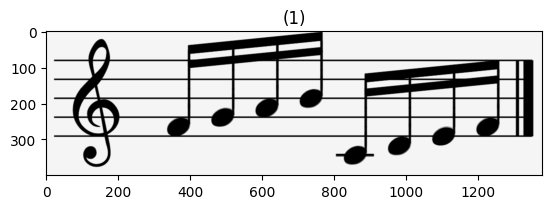

In [ ]:
img = io.imread("image12.png",as_gray=True)
print(img.shape)
# 1. Binarization

# # Compute Otsu's threshold
# otsu_threshold = threshold_otsu(img)
# binary_image_ski = img > otsu_threshold

#Adaptive ski
# # Compute a local threshold
# block_size = 201  # Size of the local region to consider
# local_thresh = threshold_local(img, block_size, offset=0)

#our threshold
# print(img)
# threshold=getThreshold(img)
# img[img>threshold]=1
# img[img<=threshold]=0

show_images([img])

In [16]:
def dynamic_binarization(input_image):
    # Calculate the histogram of the input image
    hist = cv2.calcHist([input_image], [0], None, [256], [0, 256])
    # Normalize the histogram for easier analysis
    normalized_hist = hist / hist.sum()
    
    # Check if the histogram has significant peaks near 0 and 255
    near_zero = normalized_hist[:20].sum()  # Sum of bins near 0
    near_255 = normalized_hist[-20:].sum()  # Sum of bins near 255

    # Thresholds for determining scanned images
    if near_zero+near_255 > 0.75:
        # Use Otsu's binarization for scanned images
        _, binarized_image = cv2.threshold(input_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        # Apply both Otsu and Adaptive Thresholding
        _, otsu_binary = cv2.threshold(input_image, 0, 255,cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
        adaptive_binary = cv2.adaptiveThreshold(input_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                cv2.THRESH_BINARY, blockSize=9, C=5)
        
        # Calculate the number of black pixels for Otsu's output
        otsu_black_pixels = np.sum(otsu_binary == 0)

        # Threshold for deciding noise
        noise_threshold = np.sum(hist[:120])

        if otsu_black_pixels > noise_threshold:
            # Otsu produces noise, use Adaptive Thresholding
            binarized_image = adaptive_binary
        else:
            # Otsu works fine
            binarized_image = otsu_binary

    return binarized_image



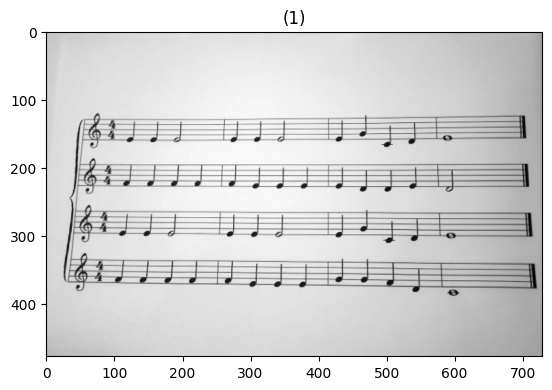

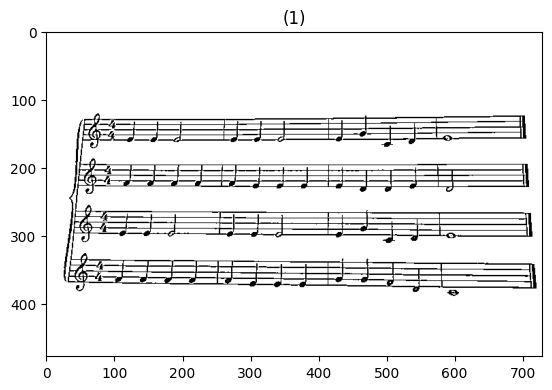

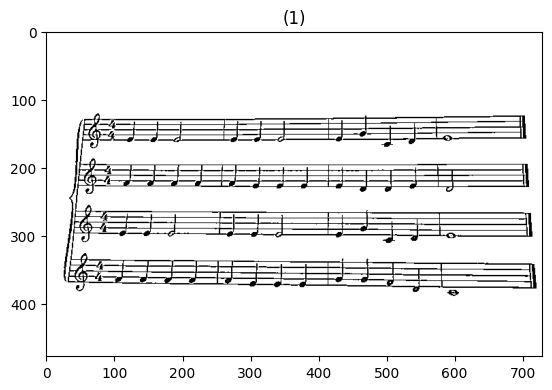

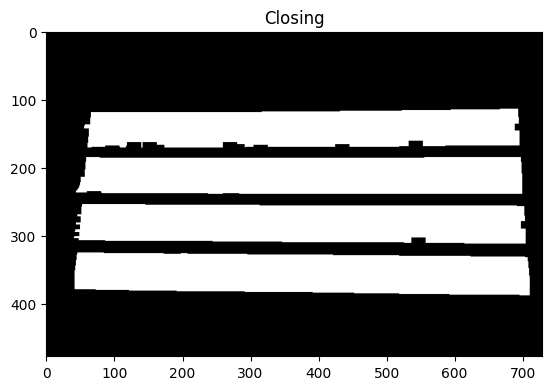

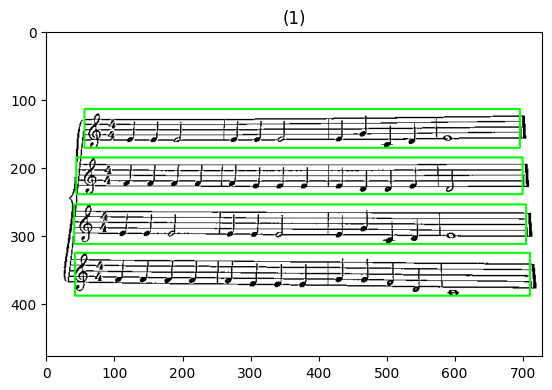

In [17]:
# Read the image
img = cv2.imread("./images/image5.png")

#remove noise using ski and opencv filters
# remove_noise = median(img)
remove_noise = cv2.bilateralFilter(img, 3, 75, 75)
# show_images([remove_noise])

# Convert to grayscale
gray = cv2.cvtColor(remove_noise, cv2.COLOR_BGR2GRAY)
# show_images([gray])
show_images([gray])
#dynamic_binarization
binarized_image=dynamic_binarization(gray)
show_images([binarized_image])

# # Apply Otsu's Thresholding
# _, binary_gaussian = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# binary_gaussian=adaptive(gray,200)

# show_images([binary_gaussian])

# grey_image = binarized_image*255
edges = cv2.Canny(gray, 50, 150)

#detect lines using Hough Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180.0, 250, np.array([]))

rotated_image=binarized_image
if lines is not None:#found lines
    _ , theta = lines[0][0]
    angle_degrees = 180 * theta / np.pi
    #rotate the image
    rotated_image = rotate(binarized_image, angle_degrees -90 , cval=255)
else:
    print("no liines")
    # plot_change(image,remove_noise,"Greyscale")

show_images([rotated_image])

#Morphology
morphology_input=255-rotated_image
morphology_input=morphology_input>0

dilation=binary_dilation(morphology_input, np.ones((25,1)))
closing=binary_erosion(dilation,footprint= np.ones((5, 21)))

show_images([closing],["Closing"])

contours_input= (closing * 255).astype('uint8')

# Find contours
contours, _ = cv2.findContours(contours_input, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw the bounding boxes
output_image = cv2.cvtColor(rotated_image, cv2.COLOR_GRAY2BGR)

# Loop over the contours to get the bounding rectangles
for contour in contours:
    # Get the bounding rectangle (x, y, width, height)
    x, y, w, h = cv2.boundingRect(contour)
    
    # Draw the rectangle on the image (BGR format for color)
    # if(w*h >50):
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result with bounding boxes
# cv2.imshow('Bounding Rectangles', output_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# img_with_boxes=closing_function(rotated_image)
show_images([output_image])